### preface

I am entering a beginner kaggle competition to demonstrate that I can do data analysis.This is for my portfolio.

This is of course, not the first time that I do data analysis; it's just that the datasets that I have been working with so far are not public, hence, I cannot publish them.

My target is to enter the top 20% on the list.
This challenge is about predicting the sale price of the house. 

For a start, let's take a look at the leaderboard to see what we are up against

From doing the tutorial, the vanillia tutorial gets a score of ~21857
Hence, if someone submits a worse score, he is not even trying.
Just by selecting a different random state for the random forrest, the score improves to 21673, or by 0.8%




### Initialisation

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.pipeline import Pipeline
import time
#import antigravity
plt.style.use('seaborn')
sns.set_style('whitegrid')

## Estabilish a achievable goal

let's take a look at the leaderboard:

In [2]:
leaders=pd.read_csv('data/home-data-for-ml-course-publicleaderboard.csv')

In [3]:
leaders.columns

Index(['TeamId', 'TeamName', 'SubmissionDate', 'Score'], dtype='object')

In [4]:
# If someone does less than 21673, he is not even trying
score_tutorial=21857
leaders.drop(leaders[leaders.Score>score_tutorial].index,inplace=True)
print(f'you have to do better than {score_tutorial} to beat the tutorial')
# if someone does better than 10k, he is probably overfitting madly
leaders.drop(leaders[leaders.Score<10000].index,inplace=True)

# sort leaders by score, and get 20th percentile score
scores=np.sort(leaders.Score.values)
score_count = scores.shape[0]
score_top20 = scores[np.int(np.floor(score_count*0.2))]
print(f'you have to do better than {score_top20:0.1f} to get to the top 20%')
score_top05 = scores[np.int(np.floor(score_count*0.05))]
print(f'you have to do better than {score_top05:0.1f} to get to the top 5%')

you have to do better than 21857 to beat the tutorial
you have to do better than 16433.6 to get to the top 20%
you have to do better than 14530.8 to get to the top 5%


In [5]:
# assuming that my score is X, what is my rating?
# find first with score larger than X
my_score = 20077.13
first_worse_score_idx=np.where(scores>my_score)[0][0]
current_rating = first_worse_score_idx/score_count
print(f'you are in the top {current_rating*100:0.2f}%, meaning, your score is better than {(1-current_rating)*100:0.3f}% of submissions')

you are in the top 52.67%, meaning, your score is better than 47.329% of submissions


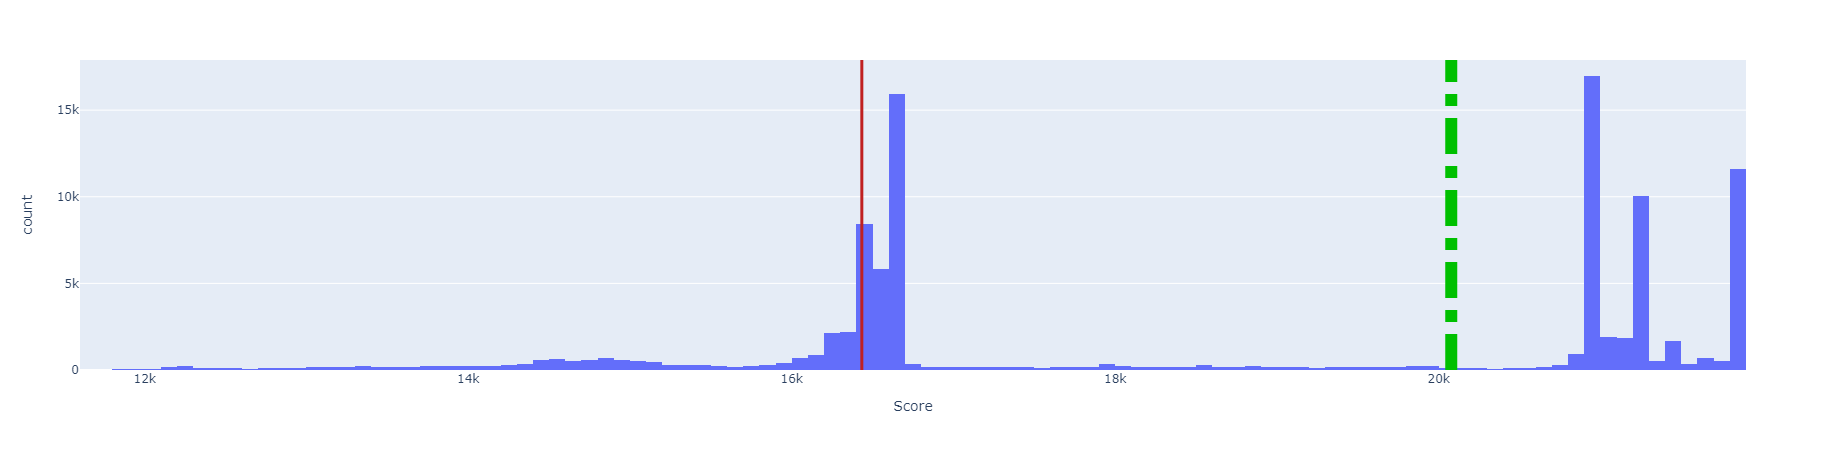

In [6]:
import plotly.express as px
fig = px.histogram(leaders, x="Score",log_y=False)
fig.update_layout({'shapes': [
            {  # Unbounded line at x = 4
                'type': 'line',
                # x-reference is assigned to the x-values
                'xref': 'x',
                # y-reference is assigned to the plot paper [0,1]
                'yref': 'paper',
                'x0': score_top20,
                'y0': 0,
                'x1': score_top20,
                'y1': 1,
                'line': {'color': 'rgb(192, 32, 32)','width': 3,},
            }
            ,
            {  # Unbounded line at x = 4
                'type': 'line',
                # x-reference is assigned to the x-values
                'xref': 'x',
                # y-reference is assigned to the plot paper [0,1]
                'yref': 'paper',
                'x0': my_score,
                'y0': 0,
                'x1': my_score,
                'y1': 1,
                'line': {'color': 'rgb(0, 192, 0)','width': 12,'dash':'dashdot'}
            }]})
fig.show()

### Strategy

#### General
1. Get to a basic fit quickly
2. Gradually engineer more features and see if that improves things
3. Keep the general code fully re-executable
4. After getting few initial features, focus on most corelated features first

#### Data cleaning strategy:
It appears that there is much to gain by just engineering the data correctly
1. Convert all categorical data into one-hot
2. Merge some categorical datas
3. Convert some numerical data into categorical - some numerical columns are actually categorical

For each feature group:
* Check missing data and "zero-data" as missing -- add a feature column "_is bad" to hint the ML not to use this sample
* Check corelation for strong nonlinearities
* Check for outliers and add them to "bad data" column

#### Programming strategy:
* Have the original training and data test always loaded, read-only (do not modify that). it gets a prefix `source_`
* Create a new, fresh data and test table from the original
* Build functions  that create fresh useful data sets
* Preserve process trace in the naming of the engineered features by using some sort of a code
* The processed data gets a prefix `p_`
* Processed nominal data gets a prefix `pn_`
* Processed ordinal data gets prefix `po_`
* Processed interval data gets prefix `pi_`
* Processed rational data gets prefix `pr_`



Notes:

4 types of data:
* N - nominal. no distance between values, e.g. categorical)  - e.g. something exists or not; 
* O - ordinal. there is ordering, but no distances between values. Can convert to categories
* I - Interval data - has distance, but there is no origin, e.g. no zero; can be added an substraced, cannot be multiplied
* R - rational data - has true zero value, allows muliplying


source: https://www.youtube.com/watch?v=SEeQgNdJ6AQ


### Load source data

In [7]:
data_train_path = 'data\\train.csv'
data_test_path = 'data\\test.csv'
src_data_train = pd.read_csv(data_train_path)
src_data_test = pd.read_csv(data_test_path)

Check the columns:

* Concept: Combine training and test data for purpose of data cleaning and transforming. This will also make it easier to do the submission later.

In [8]:
src_data_test['SalePrice']=np.NaN # training target is denoted by NaN
source_data = pd.concat((src_data_train,src_data_test))
source_data=source_data.set_index('Id')
p_original_Id=source_data.index.values
rows_test=np.where(np.isnan(source_data['SalePrice']))[0]
rows_train=np.where(~np.isnan(source_data['SalePrice']))[0]
source_data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal   208500.0  
2        0      5    2007        WD         Normal   181500.0  
3        0      9    2008        WD         Normal   223500.0  
4        0      2    2006        WD        Abnorml   140000.0  
5        0     12    2008        WD         Normal   250000.0  

[5 rows x 80 columns]

In [9]:
for idx, column in enumerate(source_data.columns):
    print(f'{idx:02d} | {column}')
print('')
print(f'data shape: {src_data_test.shape}')
print(f'test data shape: {src_data_test.shape}')

00 | MSSubClass
01 | MSZoning
02 | LotFrontage
03 | LotArea
04 | Street
05 | Alley
06 | LotShape
07 | LandContour
08 | Utilities
09 | LotConfig
10 | LandSlope
11 | Neighborhood
12 | Condition1
13 | Condition2
14 | BldgType
15 | HouseStyle
16 | OverallQual
17 | OverallCond
18 | YearBuilt
19 | YearRemodAdd
20 | RoofStyle
21 | RoofMatl
22 | Exterior1st
23 | Exterior2nd
24 | MasVnrType
25 | MasVnrArea
26 | ExterQual
27 | ExterCond
28 | Foundation
29 | BsmtQual
30 | BsmtCond
31 | BsmtExposure
32 | BsmtFinType1
33 | BsmtFinSF1
34 | BsmtFinType2
35 | BsmtFinSF2
36 | BsmtUnfSF
37 | TotalBsmtSF
38 | Heating
39 | HeatingQC
40 | CentralAir
41 | Electrical
42 | 1stFlrSF
43 | 2ndFlrSF
44 | LowQualFinSF
45 | GrLivArea
46 | BsmtFullBath
47 | BsmtHalfBath
48 | FullBath
49 | HalfBath
50 | BedroomAbvGr
51 | KitchenAbvGr
52 | KitchenQual
53 | TotRmsAbvGrd
54 | Functional
55 | Fireplaces
56 | FireplaceQu
57 | GarageType
58 | GarageYrBlt
59 | GarageFinish
60 | GarageCars
61 | GarageArea
62 | GarageQual
63 

OK, so there is 80 columns, or 78 raw data features + ID + Target

* Concept: Recognize the categorical and numerical data
Note that I will need to re-code the categorical data, and lots of feature engineering awaits me. 
Note that I will also need to re-code some numerical data


### prepare visualizers

In [10]:
def pp_tcor(column,thisdata=source_data, thistarget = 'SalePrice',polyorder=1, missingValue=1):
    '''pretty plot - target correlation with given column of the source_data
    column - name of the column from thisdata. 
    Credit: https://www.kaggle.com/abdelwahed43/house-price-prediction-apply-in-ml
    '''
    hplot = sns.regplot(data = thisdata,x=column,y=thistarget,order=polyorder,color='#e74c3c',line_kws={'color': 'black'},scatter_kws={'alpha':0.5})
    where_missing_target_is = thisdata.loc[thisdata[column].isnull()][thistarget]
    where_missing_base=np.zeros(where_missing_target_is.shape[0])+missingValue
    plt.scatter(where_missing_base,where_missing_target_is,alpha=0.5,color='green')
    return hplot
    # add plot for missing values    
    
def plot_dist3(df, feature, title):
    '''
    Create a distribution plot for given feature
    Credit: https://www.kaggle.com/datafan07/my-top-1-approach-eda-new-models-and-stacking
    
    '''    
    # Creating a customized chart. and giving in figsize and everything.
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    # creating a grid of 3 cols and 3 rows.
    
    grid = matplotlib.gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    
    ax1 = fig.add_subplot(grid[0, :2])
    
    # Set the title.
    
    ax1.set_title('Histogram')
    
    # plot the histogram.
    
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 fit=scipy.stats.norm,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])

    # customizing the QQ_plot.
    
    ax2 = fig.add_subplot(grid[1, :2])
    
    # Set the title.
    
    ax2.set_title('Probability Plot')
    
    # Plotting the QQ_Plot.
    scipy.stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    # Customizing the Box Plot:
    
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    
    ax3.set_title('Box Plot')
    
    # Plotting the box plot.
    
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=24))

    plt.suptitle(f'{title}', fontsize=24)
    print(f"Skewness {df[feature].skew():0.3f}; with log: ({pd.DataFrame(np.log1p(df[feature]),columns=[feature])[feature].skew():0.3f})")
    print(f"Kurtosis {df[feature].kurt():0.3f}; with log: ({pd.DataFrame(np.log1p(df[feature]),columns=[feature])[feature].kurt():0.3f})")
    

Skewness 1.883; with log: (0.121)
Kurtosis 6.536; with log: (0.810)


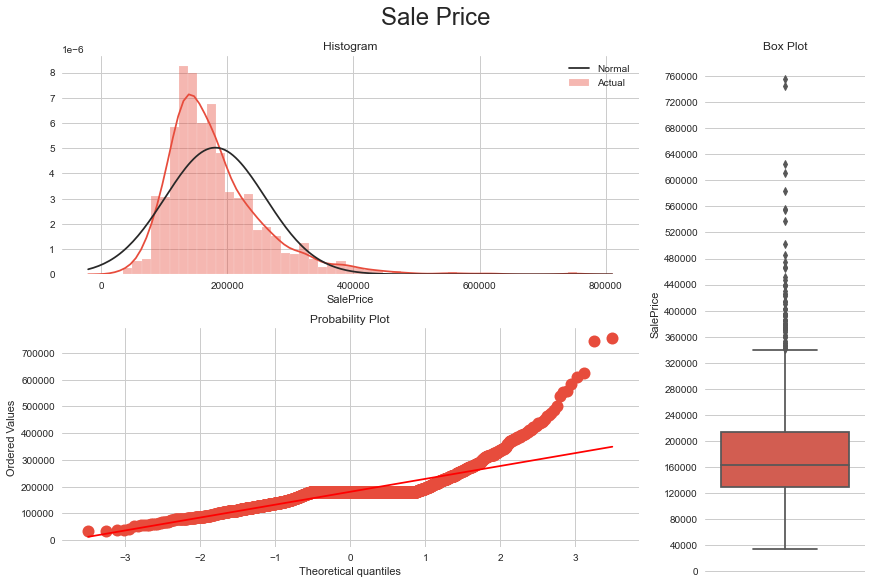

In [11]:
plot_dist3(source_data,'SalePrice','Sale Price')

In [12]:
# nominal corelation display
def nominals_significance(pn, log_source=True):
    from pandas.api.types import is_numeric_dtype
    columns=pn.columns
    
    print('------------ correlation to target_basic: ------------ ')
    corrs=[]    
    columns2=[]
    for idx, column in enumerate(columns):
        if is_numeric_dtype(pn[column]):
            corrs.append(pn[column].corr(pr_target_basic['SalePrice']))
            columns2.append(column)
    sorted_idx = np.argsort(corrs)
    
    for idx, ptr in enumerate(sorted_idx):
        print(f"{columns2[ptr]:19}:  {corrs[ptr]:+0.3}")
    
    print('------------  correlation to target_log: ------------ ')
    corrs=[]
    columns2=[]
    for idx, column in enumerate(columns):
        if is_numeric_dtype(pn[column]):
            corrs.append(pn[column].corr(pr_target_log['SalePrice']))
            columns2.append(column)
    sorted_idx = np.argsort(corrs)
    
    for idx, ptr in enumerate(sorted_idx):
        print(f"{columns2[ptr]:19}:  {corrs[ptr]:+0.3}")
        
    if (not log_source):
        return
    
    print('------------  log source correlation target_log: ------------ ')
    corrs=[]    
    columns2=[]
    for idx, column in enumerate(columns):
        if is_numeric_dtype(pn[column]):
            corrs.append(np.log1p(pn[column]).corr(pr_target_log['SalePrice']))
            columns2.append(column)
    sorted_idx = np.argsort(corrs)
    
    for idx, ptr in enumerate(sorted_idx):
        print(f"{columns2[ptr]:19}:  {corrs[ptr]:+0.3}")
    

#nominals_significance(source_data)

# Data review

#### The target column

In [13]:
pr_target_basic = pd.DataFrame(source_data['SalePrice'],index=p_original_Id)

Skewness 1.883; with log: (0.121)
Kurtosis 6.536; with log: (0.810)


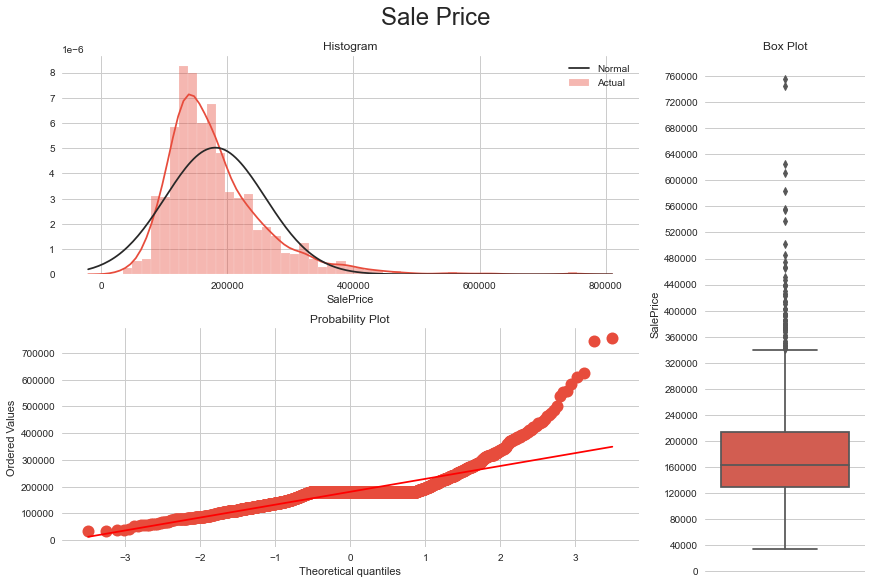

In [14]:
plot_dist3(pr_target_basic,'SalePrice','Sale Price')

Log transform skewed numeric features: We want our skewness value to be around 0 and kurtosis less than 3. 
    

In [15]:
pr_target_log1p_transformer = sklearn.preprocessing.FunctionTransformer(np.log1p,np.expm1)
# pr_target_log1p_transformer = sklearn.preprocessing.QuantileTransformer(output_distribution='normal')
pr_target_scaler = sklearn.preprocessing.RobustScaler()
pr_target_pipe= Pipeline([('log1p',pr_target_log1p_transformer),('scale',pr_target_scaler)])
import pickle

# debug: pr_target_log_raw1 = pr_target_log1p_transformer.transform(source_data.SalePrice.values.reshape(-1,1))
# debug: pr_target_log_raw2  = pr_target_scaler.fit_transform(pr_target_log_raw1)

Skewness before log transform:  1.8828757597682129
Kurtosis before log transform:  6.5362818600645305
Skewness after log transform:  0.12134661989686538
Kurtosis after log transform:  0.8095191557078807
Skewness 0.121; with log: (-1.581)
Kurtosis 0.810; with log: (4.602)


f:\prog\anaconda3\envs\dibeam\lib\site-packages\sklearn\preprocessing\_function_transformer.py:109: UserWarning:

The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.

f:\prog\anaconda3\envs\dibeam\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

invalid value encountered in log1p



<Figure size 1080x720 with 0 Axes>

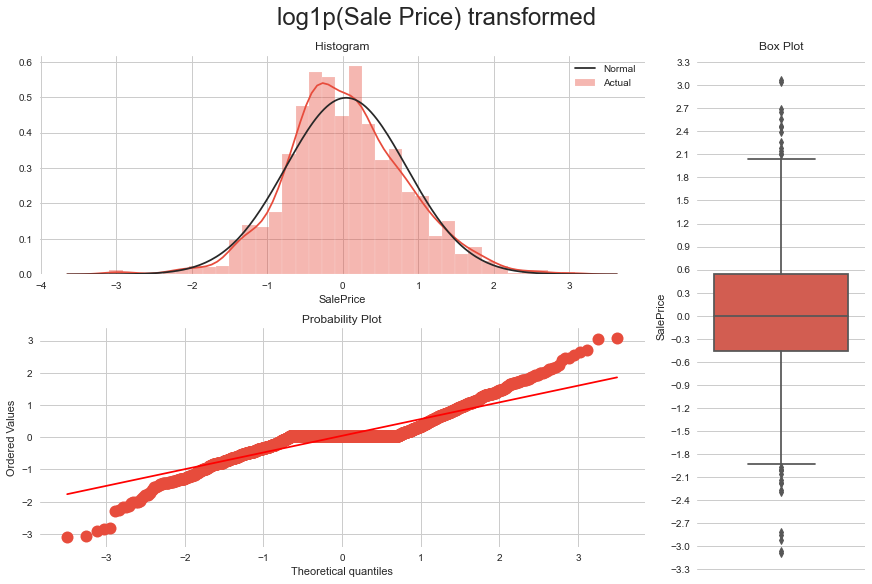

In [16]:
print("Skewness before log transform: ", pr_target_basic['SalePrice'].skew())
print("Kurtosis before log transform: ", pr_target_basic['SalePrice'].kurt())
pr_target_log_raw2 = pr_target_pipe.fit_transform(source_data.SalePrice.values.reshape(-1,1))
# the inverse function is np.expm1, which will need to be used after prediction
pr_target_log = pd.DataFrame(pr_target_log_raw2,columns=['SalePrice'],index=p_original_Id)
with open('target_transformer.pickle','wb') as f: # save the pr_target_pipe state
    pickle.dump(pr_target_pipe,f)
    
print("Skewness after log transform: ", pr_target_log['SalePrice'].skew())
print("Kurtosis after log transform: ", pr_target_log['SalePrice'].kurt())

fig = plt.figure(figsize=(15,10))
#1 rows 2 cols
#first row, first col
plot_dist3(pr_target_log,'SalePrice','log1p(Sale Price) transformed')

## Pre-engineering feature significance

In [17]:
nominals_significance(source_data)

------------ correlation to target_basic: ------------ 
KitchenAbvGr       :  -0.136
EnclosedPorch      :  -0.129
MSSubClass         :  -0.0843
OverallCond        :  -0.0779
YrSold             :  -0.0289
LowQualFinSF       :  -0.0256
MiscVal            :  -0.0212
BsmtHalfBath       :  -0.0168
BsmtFinSF2         :  -0.0114
3SsnPorch          :  +0.0446
MoSold             :  +0.0464
PoolArea           :  +0.0924
ScreenPorch        :  +0.111
BedroomAbvGr       :  +0.168
BsmtUnfSF          :  +0.214
BsmtFullBath       :  +0.227
LotArea            :  +0.264
HalfBath           :  +0.284
OpenPorchSF        :  +0.316
2ndFlrSF           :  +0.319
WoodDeckSF         :  +0.324
LotFrontage        :  +0.352
BsmtFinSF1         :  +0.386
Fireplaces         :  +0.467
MasVnrArea         :  +0.477
GarageYrBlt        :  +0.486
YearRemodAdd       :  +0.507
YearBuilt          :  +0.523
TotRmsAbvGrd       :  +0.534
FullBath           :  +0.561
1stFlrSF           :  +0.606
TotalBsmtSF        :  +0.614
Garage

In [18]:
# pr_target_recovered = pr_target_pipe.inverse_transform(pr_target_log_raw)

#### Optional : Find numeric and object columns

In [19]:
numeric_columns = source_data.select_dtypes(exclude='object').columns
categorical_columns = source_data.select_dtypes(include='object').columns
print(f'The {len(numeric_columns)} numeric columns are: \n{numeric_columns}')
print(f'The {len(categorical_columns)} categorical columns are: \n{categorical_columns}')

The 37 numeric columns are: 
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
The 43 categorical columns are: 
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposu

### Prepare the outliers column

In [20]:
is_known_outlier_empty=np.zeros(shape=source_data.shape[0],dtype=np.bool)

pn_known_outlier=pd.DataFrame(is_known_outlier_empty,columns=['is_known_outlier'],index=p_original_Id)


## add some known outliers there
pn_known_outlier.loc[pr_target_basic['SalePrice']>600000]=True

pn_known_outlier.iloc[rows_train].tail()

is_known_outlier
1456             False
1457             False
1458             False
1459             False
1460             False

### Observations
* Observation: The ID is unique and good, for both training and test data. It will enable me to kick the outliers out later on, and split the data

* Concept (for later): I will prepare it for a neural network regressor
* Concept (for later): I will train an ensemble of networks with early stopping on pre-validation data, and dropout
* Concept (for later): Instead of removing outliers, I will add new feature: "isOutlier"
* Concept (for later) : Instead of removing missing data, I will add new feature to any data that is missing, `*_ismissing`
* Concept (for later): Scale all values to 0:1 range where zero is relevant; -1 to +1 for one-hot; 
* Concept (for later): wherever ratio is relevant, add a logarithm of that feature
* Concept (for later): feature engineering: for some most relevant features, add combined features using sum and multiply; naming: `*_sum_*` and `*_mul_*`

I spot some issues here.

* Looking at the `data_description.txt`, it is clear that some of the "numeric" classes are actually categorical, and not even rational:
`MsSubClass`,

`OverallQual`
`OverallCond` 

All these ^^ will need to be converted to 1-hot so that NN can assign a value to each

Additionally, I will add more groups to `OverallQual` `OverallCond` : e.g. group1: `1,2,3,4`; group2:`3,4,5,6`; group3:`6,7,8,9`, group4:`9,10` to facilitate non-linearities

`YearBuilt`, again, split by groups, e.g. every 5 years

* Some of the categorical features, that would normally be encoded 1-hot, actually need to be combined from two columns into one:
    * `Exterior1st` and `Exterior2nd` : Exterior covering on house
    * `Condition1` and `Condition2` : Proximity to various conditions
    
Groupings:
ExterQual: Evaluates the quality of the material on the exterior 

Ex	Excellent ->5
Gd	Good ->4
TA	Average/Typical ->3
Fa	Fair ->2
Po	Poor ->1
so, again, groupings would be nice, e.g. (1,2,3),(2,3,4),(3,4,5)


* Observation: `LandSlope` might be unavailable when `LandContour` is incompatible
    
   


At this point, it is customary to:
* Check the correlation matrix
* Check which features correlate with the target (SalePrice)
* Throw away missing data

However, for this work, I take a somewhat different approach:
* I review all the features
* I never throw away any samples, but rather, add a feature saying "isOutlier" or "isUnknown" so that the NN can use the remaining data in prediction
* 

### first: MSSubClass

* OK, so there is a lot here, so let's review the features one by one. It may be tedious, but we are here to win this.

---
```
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
```
---


In [21]:
# check for missing values
source_data['MSSubClass'].isnull().sum()

0

In [22]:
MSSubClass_ids=sorted(np.unique(source_data['MSSubClass']))
MSSubClass_labels = list(map(lambda x: 'MSSubClass_'+str(x),MSSubClass_ids))
MSSubClass_lookup = pd.DataFrame(list(zip(MSSubClass_ids, MSSubClass_labels)),columns=['MSSubClass', 'MSSubClass_label'])
MSSubClass_lookup.head()

MSSubClass MSSubClass_label
0          20    MSSubClass_20
1          30    MSSubClass_30
2          40    MSSubClass_40
3          45    MSSubClass_45
4          50    MSSubClass_50

In [23]:
# Actually, pandas has a nice method to build one-hot encoding
p_MSSubClass = pd.get_dummies(source_data['MSSubClass'].astype('int32'),dummy_na=True, prefix='MSSubClass')
p_MSSubClass.head()

MSSubClass_20.0  MSSubClass_30.0  MSSubClass_40.0  MSSubClass_45.0  \
Id                                                                       
1                 0                0                0                0   
2                 1                0                0                0   
3                 0                0                0                0   
4                 0                0                0                0   
5                 0                0                0                0   

    MSSubClass_50.0  MSSubClass_60.0  MSSubClass_70.0  MSSubClass_75.0  \
Id                                                                       
1                 0                1                0                0   
2                 0                0                0                0   
3                 0                1                0                0   
4                 0                0                1                0   
5                 0                1                0                0   

    MSSubClass_80.0  MSSubClass_85.0  MSSubClass_90.0  MSSubClass_120.0  \
Id                                                                        
1                 0                0                0                 0   
2                 0                0                0                 0   
3                 0                0                0                 0   
4                 0                0                0                 0   
5                 0                0                0                 0   

    MSSubClass_150.0  MSSubClass_160.0  MSSubClass_180.0  MSSubClass_190.0  \
Id                                                                           
1                  0                 0                 0                 0   
2                  0                 0                 0                 0   
3                  0                 0                 0                 0   
4                  0                 0                 0                 0   
5                  0                 0                 0                 0   

    MSSubClass_nan  
Id                  
1                0  
2                0  
3                0  
4                0  
5                0

In [24]:
nominals_significance(p_MSSubClass)

------------ correlation to target_basic: ------------ 
MSSubClass_30.0    :  -0.239
MSSubClass_50.0    :  -0.157
MSSubClass_90.0    :  -0.115
MSSubClass_160.0   :  -0.113
MSSubClass_190.0   :  -0.0936
MSSubClass_45.0    :  -0.0829
MSSubClass_180.0   :  -0.0822
MSSubClass_85.0    :  -0.0491
MSSubClass_70.0    :  -0.0369
MSSubClass_80.0    :  -0.0286
MSSubClass_40.0    :  -0.0164
MSSubClass_75.0    :  +0.0153
MSSubClass_20.0    :  +0.0413
MSSubClass_120.0   :  +0.0629
MSSubClass_60.0    :  +0.377
MSSubClass_150.0   :  +nan
MSSubClass_nan     :  +nan
------------  correlation to target_log: ------------ 
MSSubClass_30.0    :  -0.329
MSSubClass_50.0    :  -0.174
MSSubClass_90.0    :  -0.117
MSSubClass_160.0   :  -0.115
MSSubClass_180.0   :  -0.109
MSSubClass_190.0   :  -0.105
MSSubClass_45.0    :  -0.101
MSSubClass_85.0    :  -0.0378
MSSubClass_70.0    :  -0.0311
MSSubClass_40.0    :  -0.0202
MSSubClass_80.0    :  -0.00113
MSSubClass_75.0    :  +0.0107
MSSubClass_20.0    :  +0.0548
MSSubC

### LotFrontage
LotFrontage: Linear feet of street connected to property

In [25]:
# check for missing values
source_data['LotFrontage'].isnull().sum()

486

(0.0, 200.0)

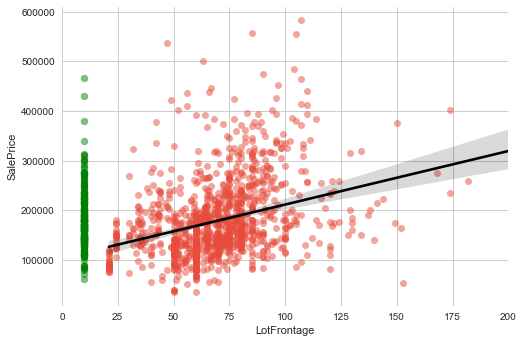

In [26]:
pp_tcor('LotFrontage', thisdata=source_data.loc[~pn_known_outlier['is_known_outlier']], polyorder=1,missingValue=10)
plt.xlim(0,200)

Skewness 1.503; with log: (-0.857)
Kurtosis 11.296; with log: (2.069)


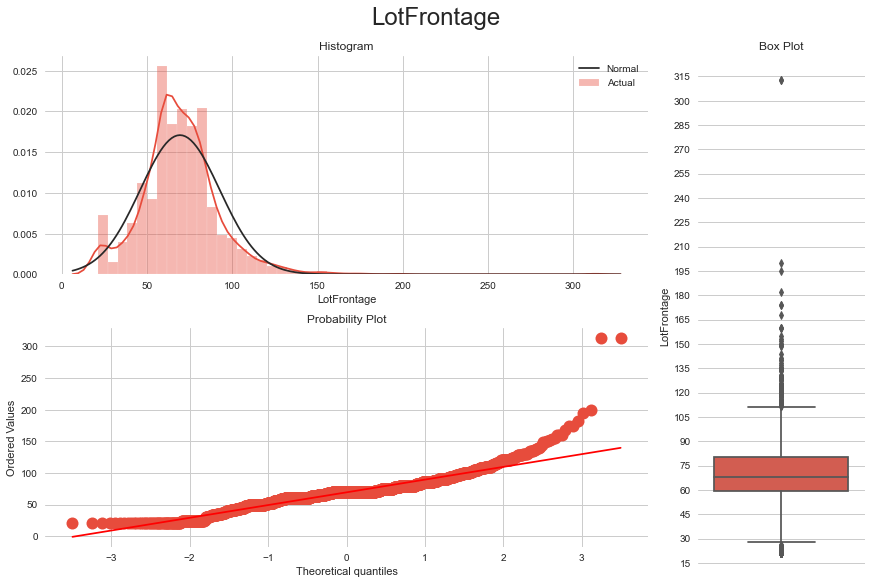

In [27]:
plot_dist3(source_data,'LotFrontage','LotFrontage')

In [28]:

p_LotFrontage_isbad = pd.DataFrame(is_known_outlier_empty,columns=['LotFrontage_isbad'],index=p_original_Id)
p_LotFrontage_isbad.loc[source_data['LotFrontage'].isnull()]=True
p_LotFrontage_isbad.loc[source_data['LotFrontage']>250]=True
p_LotFrontage_isbad.loc[source_data['LotFrontage']<10]=True
p_LotFrontage_isbad.loc[source_data['SalePrice']>500000]=True
p_LotFrontage = pd.DataFrame(source_data['LotFrontage']).join(p_LotFrontage_isbad)
print(f"training data exclusions: {p_LotFrontage_isbad['LotFrontage_isbad'].iloc[rows_train].sum()}")
print(f"test data exclusions: {p_LotFrontage_isbad['LotFrontage_isbad'].iloc[rows_test].sum()}")

training data exclusions: 270
test data exclusions: 227


(0.0, 200.0)

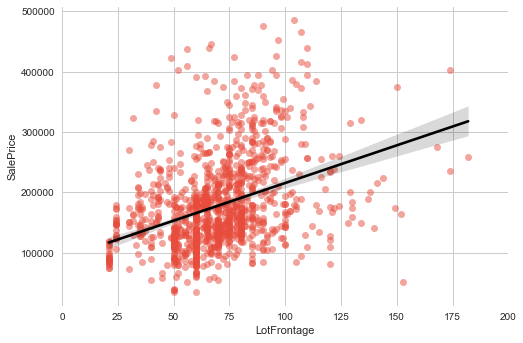

In [29]:
hplot=pp_tcor('LotFrontage', thisdata=source_data.loc[~p_LotFrontage_isbad['LotFrontage_isbad']].loc[~pn_known_outlier['is_known_outlier']], polyorder=1)
plt.xlim(0,200)

In [30]:
nominals_significance(p_LotFrontage)

------------ correlation to target_basic: ------------ 
LotFrontage_isbad  :  +0.0903
LotFrontage        :  +0.352
------------  correlation to target_log: ------------ 
LotFrontage_isbad  :  +0.0962
LotFrontage        :  +0.356
------------  log source correlation target_log: ------------ 
LotFrontage_isbad  :  +0.0962
LotFrontage        :  +0.365


In [31]:
p_LotFrontage.tail()

LotFrontage  LotFrontage_isbad
Id                                  
2915         21.0              False
2916         21.0              False
2917        160.0              False
2918         62.0              False
2919         74.0              False

### MSZoning
```
MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
```

In [32]:
print(f"MSZoning missing values:{source_data['MSZoning'].isnull().sum()}")

MSZoning missing values:4


In [33]:
p_mszoning = pd.get_dummies(source_data['MSZoning'],prefix='MSZoning',dummy_na=True)
p_mszoning.columns

Index(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'MSZoning_nan'],
      dtype='object')

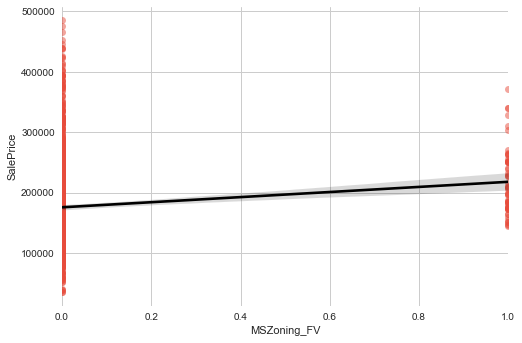

In [34]:
pp_tcor('MSZoning_FV', thisdata=p_mszoning.join(pr_target_basic).loc[~pn_known_outlier['is_known_outlier']], polyorder=1,missingValue=0)

In [35]:
nominals_significance(p_mszoning)

------------ correlation to target_basic: ------------ 
MSZoning_RM        :  -0.288
MSZoning_C (all)   :  -0.111
MSZoning_RH        :  -0.0654
MSZoning_FV        :  +0.0899
MSZoning_RL        :  +0.245
MSZoning_nan       :  +nan
------------  correlation to target_log: ------------ 
MSZoning_RM        :  -0.347
MSZoning_C (all)   :  -0.188
MSZoning_RH        :  -0.0723
MSZoning_FV        :  +0.12
MSZoning_RL        :  +0.299
MSZoning_nan       :  +nan
------------  log source correlation target_log: ------------ 
MSZoning_RM        :  -0.347
MSZoning_C (all)   :  -0.188
MSZoning_RH        :  -0.0723
MSZoning_FV        :  +0.12
MSZoning_RL        :  +0.299
MSZoning_nan       :  +nan


### LotArea
---
```
LotArea: Lot size in square feet
```

In [36]:
# check for missing values
source_data['LotArea'].isnull().sum()

0

(0.0, 1000000.0)

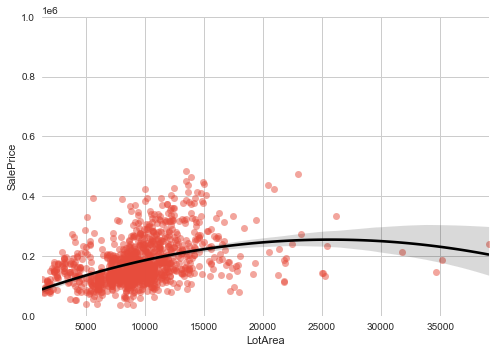

In [37]:
pn_known_outlier['is_known_outlier'].loc[source_data['LotArea']>40000]=True
pp_tcor('LotArea', thisdata=source_data.loc[~pn_known_outlier['is_known_outlier']], polyorder=2,missingValue=10)
#plt.xlim(0,200)
plt.ylim(0,1e6)


training data exclusions: 276
test data exclusions: 231


(0.0, 1000000.0)

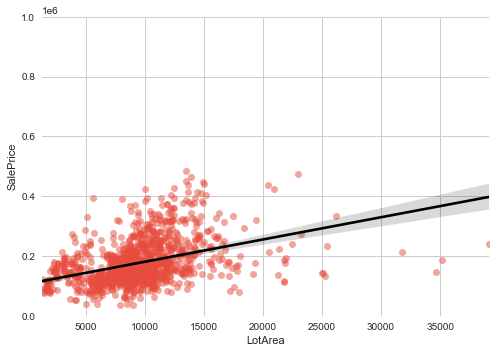

In [38]:
p_LotArea_isbad = pd.DataFrame(is_known_outlier_empty,columns=['LotArea_isbad'],index=p_original_Id)
p_LotArea_isbad.loc[source_data['LotArea'].isnull()]=True
p_LotArea_isbad.loc[source_data['LotArea']>50000]=True
p_LotArea_isbad.loc[source_data['LotArea']<10]=True
p_LotArea_isbad.loc[source_data['SalePrice']>600000]=True
p_LotArea = pd.DataFrame(source_data['LotArea']).join(p_LotArea_isbad)

print(f"training data exclusions: {p_LotArea_isbad['LotArea_isbad'].iloc[rows_train].sum()}")
print(f"test data exclusions: {p_LotArea_isbad['LotArea_isbad'].iloc[rows_test].sum()}")
hplot=pp_tcor('LotArea', thisdata=source_data.loc[~p_LotArea_isbad['LotArea_isbad']], polyorder=1)
plt.ylim(0,1e6)

In [39]:
p_LotArea_isbad['LotArea_isbad'].iloc[rows_train].sum()

276

### OverallQual
---
```
OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
```


In [40]:
source_data['OverallQual'].isnull().sum()

0

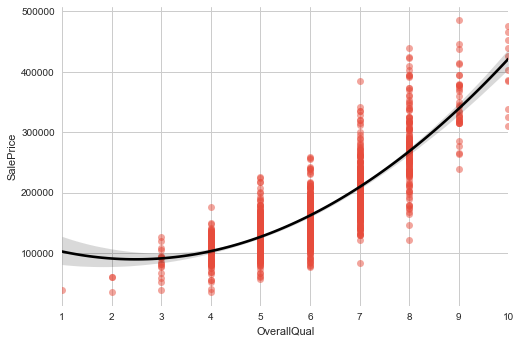

In [41]:
pp_tcor('OverallQual', thisdata=source_data.loc[~pn_known_outlier.is_known_outlier], polyorder=2,missingValue=10)

* Concept: Split this into 3 categorical columns: q1to4, q3to7, q6to9 and q10
The idea is that this will enable piecewise evaluation of this highly nonlinear and subjective feature of "quality"

In [42]:
p_OverallQual = pd.DataFrame(source_data['OverallQual'],index=p_original_Id)
p_OverallQual_1to4=pd.DataFrame(np.logical_and((source_data['OverallQual']>0) ,(source_data['OverallQual']<5)),index=p_original_Id)
p_OverallQual_3to7=pd.DataFrame(np.logical_and((source_data['OverallQual']>2) ,(source_data['OverallQual']<8)),index=p_original_Id)
p_OverallQual_6to9=pd.DataFrame(np.logical_and((source_data['OverallQual']>5) ,(source_data['OverallQual']<10)),index=p_original_Id)
p_OverallQual_10=pd.DataFrame((source_data['OverallQual']==10),index=p_original_Id)
p_OverallQual_w_categories=p_OverallQual.join(p_OverallQual_1to4,rsuffix="_1to4").join(p_OverallQual_3to7,rsuffix="_3to7").join(p_OverallQual_6to9,rsuffix="_6to9").join(p_OverallQual_10,rsuffix="_10")
#    #OverallQual_1to4.join(OverallQual_3to7,lsuffix="_1to4",rsuffix='_3to7').join(OverallQual_6to9,lsuffix="_6to9")
p_OverallQual_w_categories

OverallQual  OverallQual_1to4  OverallQual_3to7  OverallQual_6to9  \
1               7             False              True              True   
2               6             False              True              True   
3               7             False              True              True   
4               7             False              True              True   
5               8             False             False              True   
...           ...               ...               ...               ...   
2915            4              True              True             False   
2916            4              True              True             False   
2917            5             False              True             False   
2918            5             False              True             False   
2919            7             False              True              True   

      OverallQual_10  
1              False  
2              False  
3              False  
4              False  
5              False  
...              ...  
2915           False  
2916           False  
2917           False  
2918           False  
2919           False  

[2919 rows x 5 columns]

### OverallCond
---
```
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
```


In [43]:
source_data['OverallCond'].isnull().sum()

0

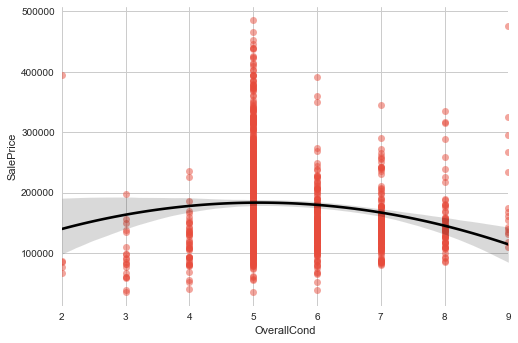

In [44]:
pp_tcor('OverallCond', thisdata=source_data.loc[~pn_known_outlier.is_known_outlier], polyorder=2,missingValue=10)

* concept: add classes: q1to4, q5, q6to9

In [45]:
p_OverallCond = pd.DataFrame(source_data['OverallCond'],index=p_original_Id)
p_OverallCond_1to4=pd.DataFrame(np.logical_and((source_data['OverallCond']>0) ,(source_data['OverallCond']<5)),index=p_original_Id)
p_OverallCond_5=pd.DataFrame((source_data['OverallCond']==5), index=p_original_Id)
p_OverallCond_6to9=pd.DataFrame((source_data['OverallCond']>5), index=p_original_Id)
p_OverallCond_w_categories=p_OverallCond.join(p_OverallCond_1to4,rsuffix="_1to4").join(p_OverallCond_5,rsuffix="_5").join(p_OverallCond_6to9,rsuffix="_6to9")
p_OverallCond_w_categories

OverallCond  OverallCond_1to4  OverallCond_5  OverallCond_6to9
1               5             False           True             False
2               8             False          False              True
3               5             False           True             False
4               5             False           True             False
5               5             False           True             False
...           ...               ...            ...               ...
2915            7             False          False              True
2916            5             False           True             False
2917            7             False          False              True
2918            5             False           True             False
2919            5             False           True             False

[2919 rows x 4 columns]

In [46]:
nominals_significance(p_OverallCond_w_categories)

------------ correlation to target_basic: ------------ 
OverallCond_6to9   :  -0.223
OverallCond_1to4   :  -0.208
OverallCond        :  -0.0779
OverallCond_5      :  +0.317
------------  correlation to target_log: ------------ 
OverallCond_1to4   :  -0.284
OverallCond_6to9   :  -0.21
OverallCond        :  -0.0369
OverallCond_5      :  +0.341
------------  log source correlation target_log: ------------ 
OverallCond_1to4   :  -0.284
OverallCond_6to9   :  -0.21
OverallCond        :  -0.00179
OverallCond_5      :  +0.341


* Q: is p_OverallCond correlated with p_OverallQual?

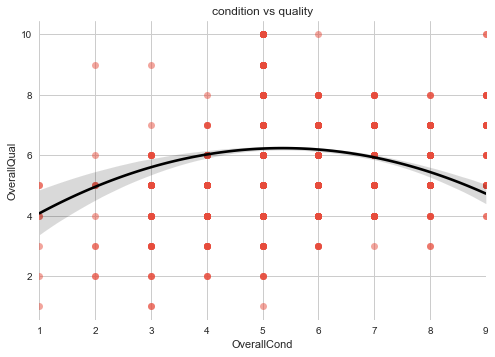

In [47]:
#data = thisdata,x=column,y=thistarget,order=polyorder,color='#e74c3c',line_kws={'color': 'black'},scatter_kws={'alpha':0.5}
sns.regplot(data=source_data, x='OverallCond', y='OverallQual',color='#e74c3c',line_kws={'color': 'black'},scatter_kws={'alpha':0.5},order=2)
plt.title('condition vs quality');

## YearBuilt
---
```
YearBuilt: Original construction date
```


missing values:0


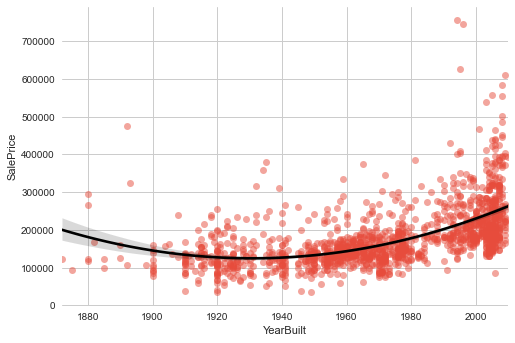

In [48]:
print(f"missing values:{source_data['YearBuilt'].isnull().sum()}")
pp_tcor('YearBuilt', thisdata=source_data, polyorder=2,missingValue=10)

In [49]:
p_YearBuilt = pd.DataFrame(source_data['YearBuilt'],index=p_original_Id)
p_YearBuilt_veryold=pd.DataFrame(source_data['YearBuilt']<1910,index=p_original_Id)
p_YearBuilt_verynew=pd.DataFrame(source_data['YearBuilt']>2000,index=p_original_Id)
p_YearBuilt_w_categories=p_YearBuilt.join(p_YearBuilt_veryold,rsuffix='_veryold').join(p_YearBuilt_verynew,rsuffix='_verynew')

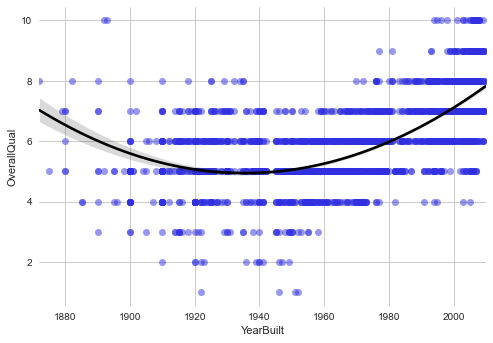

In [50]:
sns.regplot(data=source_data, x='YearBuilt', y='OverallQual',color='#3030e0',line_kws={'color': 'black'},scatter_kws={'alpha':0.5},order=2);

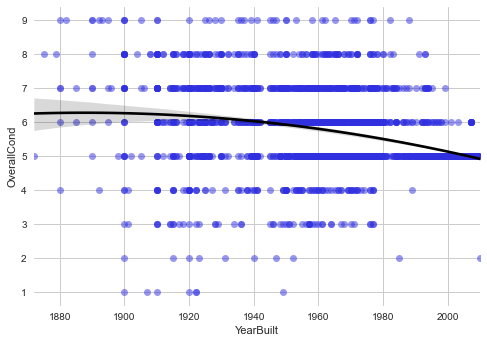

In [51]:
sns.regplot(data=source_data, x='YearBuilt', y='OverallCond',color='#3030e0',line_kws={'color': 'black'},scatter_kws={'alpha':0.5},order=2);

### YearRemodAdd
---

```
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
```

missing values:0


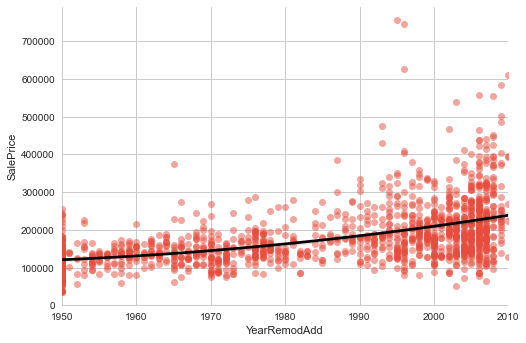

In [52]:
print(f"missing values:{source_data['YearRemodAdd'].isnull().sum()}")
pp_tcor('YearRemodAdd', thisdata=source_data, polyorder=2,missingValue=10);

In [53]:
p_YearRemodAdd=pd.DataFrame(source_data['YearRemodAdd'],index=p_original_Id)
p_YearRemodAdd_bad=pd.DataFrame(source_data['YearRemodAdd']<1952,index=p_original_Id)
p_YearRemodAdd_w=p_YearRemodAdd.join(p_YearRemodAdd_bad,rsuffix='_bad')

### MasVnrType
---
```
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
```        

In [54]:
print(f"missing values:{source_data['MasVnrType'].isnull().sum()}")
p_MasVnrType=pd.get_dummies(source_data['MasVnrType'],prefix='MasVnrType_',dummy_na=True)
p_MasVnrType.columns

missing values:24


Index(['MasVnrType__BrkCmn', 'MasVnrType__BrkFace', 'MasVnrType__None',
       'MasVnrType__Stone', 'MasVnrType__nan'],
      dtype='object')

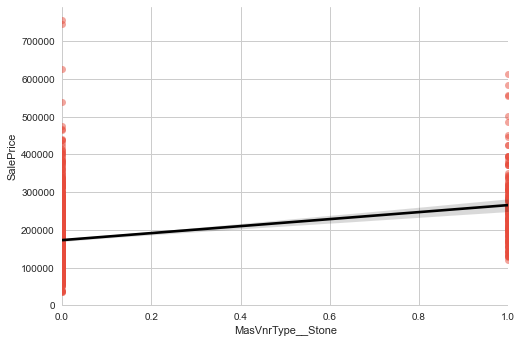

In [55]:
pp_tcor('MasVnrType__Stone', thisdata=p_MasVnrType.join(pr_target_basic), polyorder=1,missingValue=0)

### MasVnrArea
---
```
MasVnrArea: Masonry veneer area in square feet
```

missing values:23


(0.0, 700000.0)

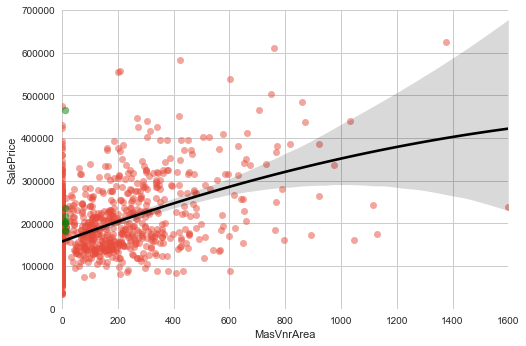

In [56]:
print(f"missing values:{source_data['MasVnrArea'].isnull().sum()}")
pp_tcor('MasVnrArea', thisdata=source_data, polyorder=2,missingValue=10)
plt.ylim(0,700e3)

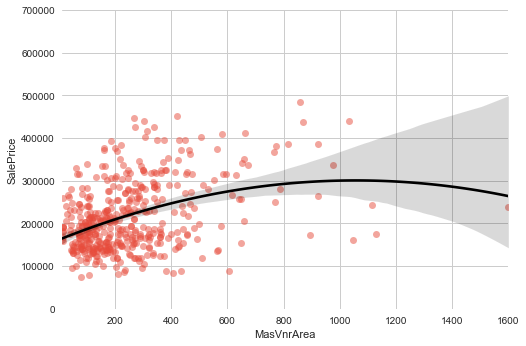

In [57]:
p_MasVnrArea=pd.DataFrame(source_data['MasVnrArea'],index=p_original_Id)
p_MasVnrArea_isbad = pd.DataFrame(is_known_outlier_empty,columns=['MasVnrArea_isbad'],index=p_original_Id)
p_MasVnrArea_isbad.loc[source_data['MasVnrArea'].isnull()]=True
p_MasVnrArea_isbad.loc[source_data['MasVnrArea']<10]=True
p_MasVnrArea_w=p_MasVnrArea.join(p_MasVnrArea_isbad).join(p_MasVnrType)
hplot=pp_tcor('MasVnrArea', thisdata=source_data.loc[~p_MasVnrArea_isbad['MasVnrArea_isbad']], polyorder=2)
plt.ylim(0,700e3);

### Basement features

`BsmtFinType1`, `BsmtFinType2`, `BsmtFinSF1`, `BsmtFinSF2`,`BsmtUnfSF`, `TotalBsmtSF`, `1stFlrSF`, `2ndFlrSF`, `LowQualFinSF`,`GrLivArea`

```
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area
```

* From these features, i select BsmtFinType1 and TotalBsmtSF.


In [58]:
print(f"BsmtFinType1 missing values:{source_data['BsmtFinType1'].isnull().sum()}")
print(f"TotalBsmtSF missing values:{source_data['TotalBsmtSF'].isnull().sum()}")

BsmtFinType1 missing values:79
TotalBsmtSF missing values:1


In [59]:
basementType1=pd.get_dummies(source_data['BsmtFinType1'],prefix='BsmtFinType_',dummy_na=True)
basementType1=pd.get_dummies(source_data['BsmtFinType2'],prefix='BsmtFinType_',dummy_na=True)
p_basement_type=basementType1+basementType1
# fix double countings
p_basement_type['BsmtFinType__BLQ'].loc[p_basement_type['BsmtFinType__BLQ']==2]=1
p_basement_type['BsmtFinType__Unf'].loc[p_basement_type['BsmtFinType__Unf']==2]=1
p_basement_type['BsmtFinType__nan'].loc[p_basement_type['BsmtFinType__nan']==2]=1

p_basementSize=pd.DataFrame(source_data['TotalBsmtSF'],index=p_original_Id)


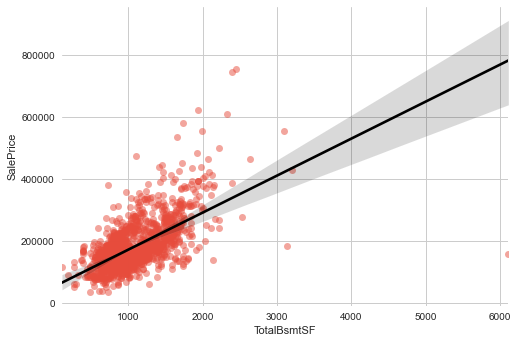

In [60]:
pp_tcor('TotalBsmtSF', thisdata=source_data.loc[p_basement_type['BsmtFinType__nan']==0], polyorder=1,missingValue=10)

In [61]:
p_basement_w=p_basementSize.join(p_basement_type)

### Street, alley, lot shape, LandContour
```
Street: Type of road access to property
Alley: Type of alley access to property
LotShape: General shape of property
LandContour: Flatness of the property
```

In [62]:
print(f"Street missing values:{source_data['Street'].isnull().sum()}")
print(f"Alley missing values:{source_data['Alley'].isnull().sum()}")
print(f"LotShape missing values:{source_data['LotShape'].isnull().sum()}")
print(f"LandContour missing values:{source_data['LandContour'].isnull().sum()}")

Street missing values:0
Alley missing values:2721
LotShape missing values:0
LandContour missing values:0


In [63]:
p_streettype=pd.get_dummies(source_data['Street'],prefix='Street_')
p_alleytype=pd.get_dummies(source_data['Alley'],prefix='Alley_',dummy_na=True)
p_lotshape = pd.get_dummies(source_data['LotShape'],prefix='LotShape_',dummy_na=True)
p_landcontour = pd.get_dummies(source_data['LandContour'],prefix='LandContour_',dummy_na=True)
p_street_alley_lot_land_contour = p_streettype.join(p_alleytype).join(p_lotshape).join(p_landcontour)

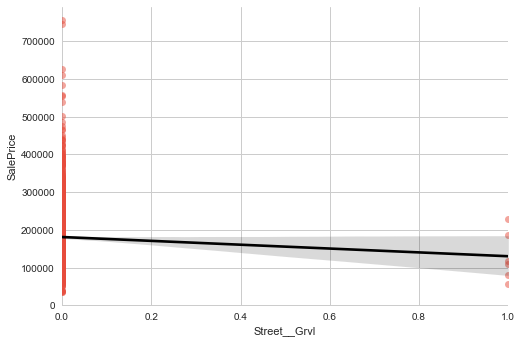

In [64]:
pp_tcor('Street__Grvl', thisdata=p_streettype.join(pr_target_basic), polyorder=1,missingValue=0)

In [65]:
p_streettype.iloc[rows_test]['Street__Grvl'].sum()

6

In [66]:
#return

### GrLivArea
```
GrLivArea: Above grade (ground) living area square feet
```

In [67]:
print(f"GrLivArea missing values:{source_data['GrLivArea'].isnull().sum()}")

GrLivArea missing values:0


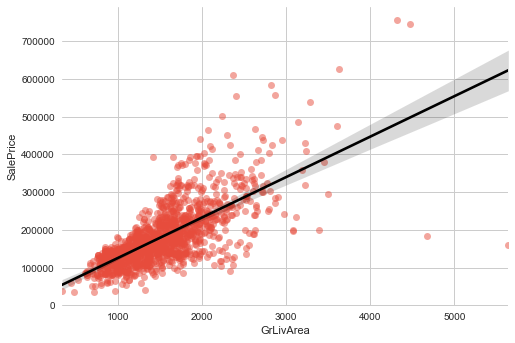

In [68]:
pp_tcor('GrLivArea', thisdata=source_data, polyorder=1,missingValue=0)

In [69]:
# it seems that it's OK to just copy it as-is,
p_GrLivArea = pd.DataFrame(source_data['GrLivArea'],index=p_original_Id)
p_MasVnrArea_isbad = pd.DataFrame(is_known_outlier_empty,columns=['MasVnrArea_isbad'],index=p_original_Id)
p_MasVnrArea_isbad.loc[source_data['MasVnrArea'].isnull()]=True

### GarageCars, GarageArea, GarageQual
```
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       
```

Skewness -0.218; with log: (-1.276)
Kurtosis 0.238; with log: (1.978)
Skewness 0.241; with log: (-3.523)
Kurtosis 0.940; with log: (11.534)


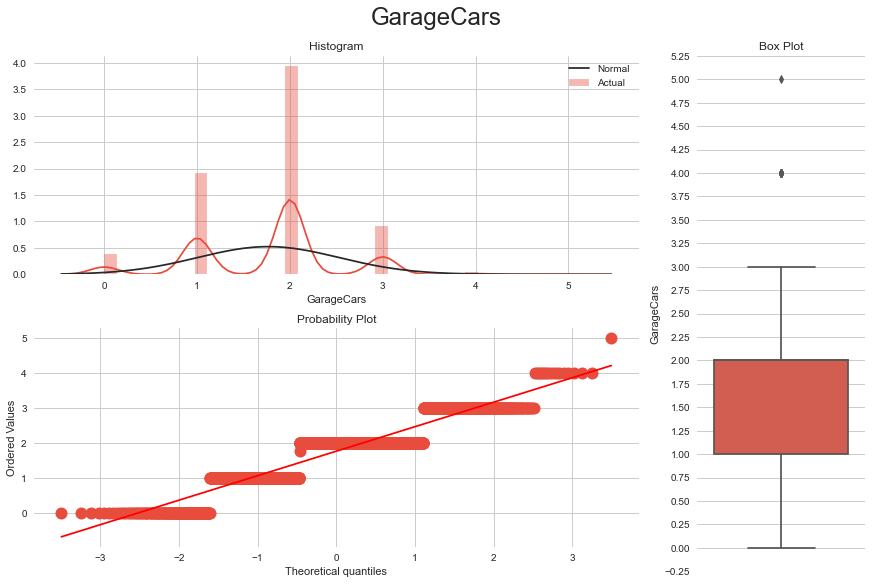

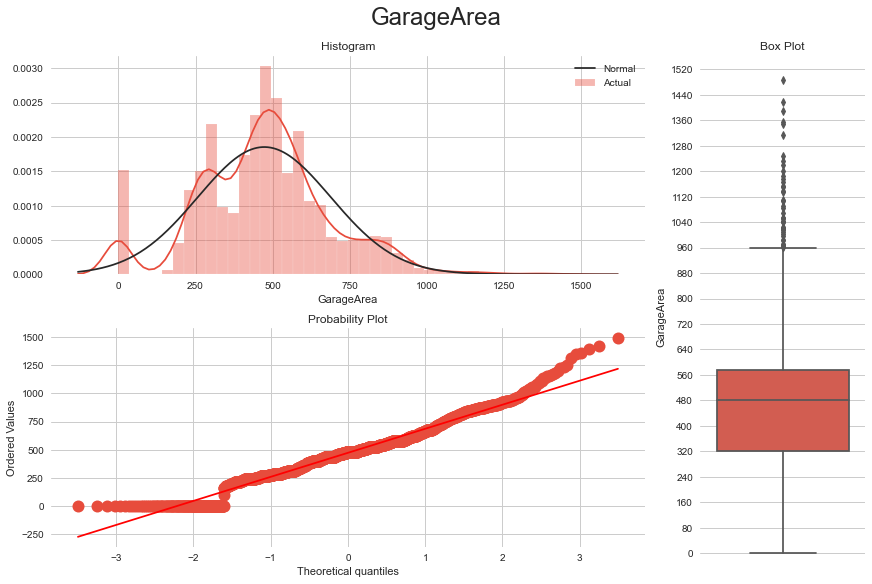

In [70]:
plot_dist3(source_data,'GarageCars','GarageCars')
plot_dist3(source_data,'GarageArea','GarageArea')

Observation: There is no need to transform the GarageCars nor GarageArea


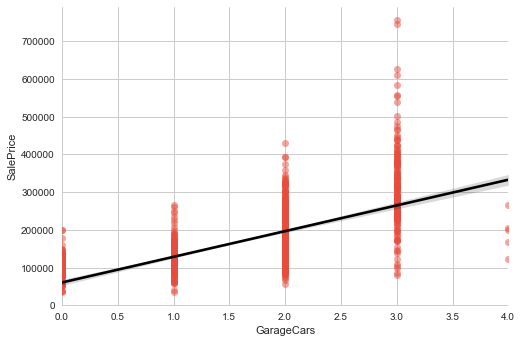

In [71]:
pp_tcor('GarageCars', thisdata=source_data, polyorder=1,missingValue=0);

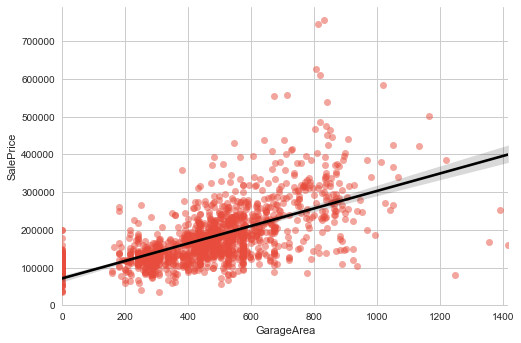

In [72]:
pp_tcor('GarageArea', thisdata=source_data, polyorder=1,missingValue=0);

```
(done) GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
		
```

In [73]:
pn_GarageCond=pd.get_dummies(source_data['GarageCond'],prefix='GarageCond_',dummy_na=True)
pn_PavedDrive=pd.get_dummies(source_data['PavedDrive'],prefix='PavedDrive_',dummy_na=True)
pn_GarageQual=pd.get_dummies(source_data['GarageQual'],prefix='GarageQual_',dummy_na=True)

In [74]:
pr_garageCars=pd.DataFrame(source_data['GarageCars'],index=p_original_Id)
pr_garageArea=pd.DataFrame(source_data['GarageArea'],index=p_original_Id)
prn_garage = pn_GarageQual.join(pn_GarageCond).join(pn_PavedDrive).join(pr_garageCars).join(pr_garageArea)
nominals_significance(prn_garage)

------------ correlation to target_basic: ------------ 
GarageQual__nan    :  -0.237
GarageCond__nan    :  -0.237
PavedDrive__N      :  -0.213
GarageQual__Fa     :  -0.133
GarageCond__Fa     :  -0.131
PavedDrive__P      :  -0.0886
GarageCond__Po     :  -0.0633
GarageQual__Po     :  -0.0461
GarageCond__Ex     :  -0.0265
GarageCond__Gd     :  -0.000983
GarageQual__Ex     :  +0.0343
GarageQual__Gd     :  +0.0433
PavedDrive__Y      :  +0.232
GarageQual__TA     :  +0.245
GarageCond__TA     :  +0.276
GarageArea         :  +0.623
GarageCars         :  +0.64
PavedDrive__nan    :  +nan
------------  correlation to target_log: ------------ 
GarageQual__nan    :  -0.323
GarageCond__nan    :  -0.323
PavedDrive__N      :  -0.286
GarageCond__Fa     :  -0.168
GarageQual__Fa     :  -0.161
PavedDrive__P      :  -0.0953
GarageCond__Po     :  -0.0784
GarageQual__Po     :  -0.0627
GarageCond__Ex     :  -0.0275
GarageCond__Gd     :  +0.00524
GarageQual__Ex     :  +0.0172
GarageQual__Gd     :  +0.0483
Paved

```
       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
```

# OK, so at this point, I have cleaned some features.

I can attempt to run a basic regressor on this already





In [75]:
# add garage, with log target:
p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(p_OverallQual_w_categories).join(p_OverallCond_w_categories).join(p_YearBuilt_w_categories) 
p_data=p_data.join(p_YearRemodAdd_w).join(p_MasVnrArea_w).join(p_basement_w).join(p_street_alley_lot_land_contour).join(p_GrLivArea).join(p_mszoning).join(prn_garage)
# -> best error(by chance): 11466.26; best config is with max. error 20077.13 for depth=10, rounds=44, eta=0.2, subsampling = 1.0;  typical error: 33215.60 ±13607.7


# p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(p_OverallQual_w_categories).join(p_OverallCond_w_categories).join(p_YearBuilt_w_categories) 
# p_data=p_data.join(p_YearRemodAdd_w).join(p_MasVnrArea_w).join(p_basement_w).join(p_street_alley_lot_land_contour).join(p_GrLivArea).join(p_mszoning) # ->  best error: 22147.61 for depth=12, rounds=27, eta=0.3, subsampling = 1.0;  typical error: 28954.50 ±3216.7; incl. log target

nominals_significance(p_data)
#p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(p_OverallQual_w_categories).join(p_OverallCond_w_categories).join(p_YearBuilt_w_categories) 
#p_data=p_data.join(p_YearRemodAdd_w).join(p_MasVnrArea_w).join(p_basement_w).join(p_street_alley_lot).join(p_GrLivArea) # ->  best error: 22677.25 for depth=8, rounds=27, eta=0.4, subsampling = 1.0;  typical error: 30599.87 ±5870.1


# p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(p_OverallQual_w_categories).join(p_OverallCond_w_categories).join(p_YearBuilt_w_categories) 
# p_data=p_data.join(p_YearRemodAdd_w).join(p_MasVnrArea_w).join(p_basement_w).join(p_street_alley_lot) # ->  best error: 24990.36 for depth=9, rounds=15, eta=0.4, subsampling = 1.0;  typical error: 34621.37 ±4048.2

# p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(p_OverallQual_w_categories).join(p_OverallCond_w_categories).join(p_YearBuilt_w_categories) 
# p_data=p_data.join(p_YearRemodAdd_w).join(p_MasVnrArea_w).join(p_basement_w) # -> best error: 35832.18 for depth=2, rounds=400, eta=0.7, subsampling = 0.9;  typical error: 39358.18 ±3484.4


# p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(p_OverallQual_w_categories).join(p_OverallCond_w_categories).join(p_YearBuilt_w_categories) 
# p_data=p_data.join(p_YearRemodAdd_w).join(p_MasVnrArea_w).join(p_basement_w) # -> best error: 32975.65 for depth=2, rounds=400, eta=0.7, subsampling = 0.9;  typical error: 37153.24 ±5492.6

#p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(p_OverallQual_w_categories).join(p_OverallCond_w_categories).join(p_YearBuilt_w_categories) #->best error: 33384.01 for depth=2, rounds=34, eta=0.8, subsampling = 1.0;  typical error: 51329.24 ±8548.7
#p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(OverallQual_w_categories).join(p_OverallCond_w_categories) #->44257.20 ±6970.3
#p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotFrontage).join(p_LotArea).join(OverallQual_w_categories) # -> 44394.47 ±6948.3
# p_data=pn_known_outlier.join(p_MSSubClass).join(p_LotArea) #-> 72267.44 ±6708.3
# reminder: training target: p_target_basic

p_data.to_pickle('p_data.pickle')
pr_target_log.to_pickle('p_target_transformed.pickle')

------------ correlation to target_basic: ------------ 
OverallQual_3to7   :  -0.653
MasVnrType__None   :  -0.374
OverallQual_1to4   :  -0.319
YearRemodAdd_bad   :  -0.3
is_known_outlier   :  -0.291
MasVnrArea_isbad   :  -0.291
MSZoning_RM        :  -0.288
LotShape__Reg      :  -0.268
MSSubClass_30.0    :  -0.239
GarageCond__nan    :  -0.237
GarageQual__nan    :  -0.237
OverallCond_6to9   :  -0.223
PavedDrive__N      :  -0.213
OverallCond_1to4   :  -0.208
MSSubClass_50.0    :  -0.157
BsmtFinType__nan   :  -0.145
Alley__Grvl        :  -0.139
GarageQual__Fa     :  -0.133
GarageCond__Fa     :  -0.131
MSSubClass_90.0    :  -0.115
MSSubClass_160.0   :  -0.113
MSZoning_C (all)   :  -0.111
LandContour__Bnk   :  -0.101
MSSubClass_190.0   :  -0.0936
PavedDrive__P      :  -0.0886
MSSubClass_45.0    :  -0.0829
MSSubClass_180.0   :  -0.0822
OverallCond        :  -0.0779
MSZoning_RH        :  -0.0654
GarageCond__Po     :  -0.0633
BsmtFinType__BLQ   :  -0.0571
MSSubClass_85.0    :  -0.0491
YearBuilt

In [76]:
p_data.shape

(2919, 91)

In [77]:
grid_rounds=np.int32(np.logspace(np.log10(5.0),np.log10(500),25))
print(grid_rounds)

[  5   6   7   8  10  13  15  19  23  28  34  41  49  60  73  88 107 130
 158 191 232 281 340 412 499]


In [78]:
import random
random.seed()

In [79]:
# !! "Edit" settings. For actual grid search, go to "*.compute*" notebook
grid_depths=[2] # grid_depths=[2,3,4,5,6,7,8,9]
grid_eta=[0.7]
grid_rounds=[400]
grid_internal_subsampling=[0.9]

validation_errors=[]
t_learning_costs=[]

t_etas=[]
t_depths=[]
t_rounds=[]
t_subsamplings=[]

best_depth=np.NaN;
best_rounds=np.NaN;
best_eta=np.NaN;
best_subsampling = np.NaN;

for local_subsampling in grid_internal_subsampling:
    for local_depth in grid_depths:
        for local_eta in grid_eta:        
            for local_rounds in grid_rounds:
                local_parameters = {
                    'max_depth':local_depth,
                    'eta':local_eta, 
                    'objective':'reg:squarederror',
                    'subsample':local_subsampling }
                random.seed(0)            
                rs = sklearn.model_selection.ShuffleSplit(n_splits=3, test_size=0.10, random_state=0)
                for train_index, validation_index in rs.split(rows_train):
                    xgb_train = xgb.DMatrix(p_data.iloc[train_index], label=pr_target_basic.iloc[train_index])
                    xgb_validation = xgb.DMatrix(p_data.iloc[validation_index],label=pr_target_basic.iloc[validation_index])
                    validation_target_values = pr_target_basic.iloc[validation_index]['SalePrice']
                    t0=time.perf_counter_ns()
                    bst = xgb.train(local_parameters, xgb_train, local_rounds)    
                    validation_prediction = bst.predict(xgb_validation)
                    t_learning_cost=time.perf_counter_ns()-t0
                    validation_error=np.sqrt(np.mean(np.square(validation_target_values-validation_prediction)))    

                    validation_errors.append(validation_error)                
                    t_learning_costs.append(t_learning_cost)
                    t_etas.append(local_eta)
                    t_depths.append(local_depth)
                    t_rounds.append(local_rounds)
                    t_subsamplings.append(local_subsampling)

                    if validation_error==np.min(validation_errors):
                        best_depth=local_depth
                        best_rounds=local_rounds
                        best_eta=local_eta
                        best_subsampling = local_subsampling
                

min_error=np.min(validation_errors);
max_error=np.max(validation_errors);
mean_error=np.mean(validation_errors)
std_error=np.std(validation_errors)
print(f'best error: {min_error:0.2f} for depth={best_depth}, rounds={best_rounds}, eta={best_eta}, subsampling = {best_subsampling};  typical error: {mean_error:0.2f} ±{std_error:0.1f}')    
    

best error: 31877.40 for depth=2, rounds=400, eta=0.7, subsampling = 0.9;  typical error: 36983.10 ±3610.4



display_err_min=30000
display_err_max=40000
plt.scatter(validation_errors,np.array(t_learning_costs)*1e-9)
plt.xlabel('validation error[USD]')
plt.ylabel('training cost[seconds]')
plt.ylim(0,0.05)
plt.xlim(display_err_min,display_err_max)
plt.title('training cost[sec]')
plt.show()

plt.scatter(validation_errors,t_etas)
plt.xlabel('validation error[USD]')
plt.ylabel('parameter: eta')
plt.title('selection of ETA')
plt.xlim(display_err_min,display_err_max)
plt.show()

plt.scatter(validation_errors,t_depths)
plt.xlabel('validation error[USD]')
plt.ylabel('parameter: t_depth')
plt.title('selection of forrest depth')
plt.xlim(display_err_min,display_err_max)
plt.show()


plt.scatter(validation_errors,t_rounds)
plt.xlabel('validation error[USD]')
plt.ylabel('parameter: t_rounds')
plt.title('selection of training rounds count')
plt.xlim(display_err_min,display_err_max)
plt.show()


plt.scatter(validation_errors,t_subsamplings)
plt.xlabel('validation error[USD]')
plt.ylabel('parameter: t_subsamplings')
plt.title('selection of t_subsamplings ')
plt.xlim(display_err_min,display_err_max)
plt.show()

